In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

In [2]:
data_table_brain = pd.read_parquet("intermediate_data/data_table_brain.gzip")
beta_df = pd.read_csv("intermediate_data/beta_df.csv")
print(beta_df.shape)
beta_df.head()
# pip install fastparquet # if it doesnt work

(191, 10)


,Unnamed: 0,index,Var1,files,len,0,1,2,3,labels
0,0,0,Sn(1) choice_tr1_defect_R+S-*bf(1),beta_0001.nii,34,Sn(1) choice,tr1,defect,R+S-*bf(1),0
1,1,1,Sn(1) choice_tr2_cooperate_R+S+*bf(1),beta_0002.nii,37,Sn(1) choice,tr2,cooperate,R+S+*bf(1),1
2,2,2,Sn(1) choice_tr3_cooperate_R+S-*bf(1),beta_0003.nii,37,Sn(1) choice,tr3,cooperate,R+S-*bf(1),1
3,3,3,Sn(1) choice_tr4_defect_R-S-*bf(1),beta_0004.nii,34,Sn(1) choice,tr4,defect,R-S-*bf(1),0
4,4,4,Sn(1) choice_tr5_defect_R-S+*bf(1),beta_0005.nii,34,Sn(1) choice,tr5,defect,R-S+*bf(1),0


In [3]:
print(data_table_brain.shape)
data_table_brain.head()

(41712, 196)


,index,x,y,z,brain_mask,beta0,beta1,beta2,beta3,beta4,...,beta181,beta182,beta183,beta184,beta185,beta186,beta187,beta188,beta189,beta190
0,23149,7,18,29,1.0,2.185793,0.216214,0.898458,-0.767733,0.980242,...,1.751049,2.173206,-0.770652,-0.555270,2.946541,0.775639,-0.083898,2.876902,-1.708210,-6.542468
1,23150,7,18,30,1.0,2.262514,0.176321,1.067624,-0.753252,1.558099,...,0.949927,2.077133,-1.343127,-0.579337,3.244278,2.489923,0.354420,2.482962,-1.911663,-7.082224
2,23155,7,18,35,1.0,1.409987,0.308808,1.552267,2.061087,1.836347,...,0.746239,1.372045,1.485866,3.634712,3.846372,6.075477,0.973503,0.920017,-1.207945,-4.028594
3,23156,7,18,36,1.0,0.969699,-0.110201,1.039446,2.290150,1.154906,...,1.111888,0.921008,-0.040704,2.912729,2.266409,4.096661,0.770709,1.018212,-1.520981,-1.951829
4,23229,7,20,29,1.0,1.887761,0.605765,0.851713,0.236050,1.783170,...,1.377842,1.957112,-0.367890,0.924748,2.684568,2.028383,0.284075,1.735687,-1.399973,-6.692441


### Create training data and lables


In [4]:
X = np.array(data_table_brain.iloc[:,5:]).T
print(X.shape)
type(X)

(191, 41712)


numpy.ndarray

In [5]:
Y = np.array(beta_df["labels"])
print(Y.shape)
type(Y)

(191,)


numpy.ndarray

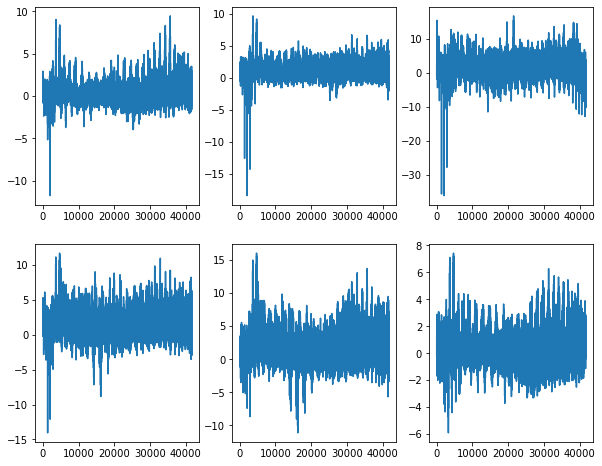

In [6]:
plt.figure(figsize=(10,8))
for i in range(1,7):
    plt.subplot(2,3,i)
    plt.plot(X[i,:])

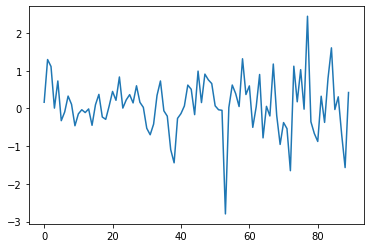

In [7]:
plt.plot(X[10:100,10])

### Dimensionality reduction

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import time
import os
from scipy.stats import norm

In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X.shape

(191, 41712)

In [10]:
pca = PCA(n_components=25)
Xpca = pca.fit_transform(X)
Xpca.shape

(191, 25)

In [11]:
res = pd.DataFrame(Xpca)
res["y"] = Y

<AxesSubplot:xlabel='0', ylabel='1'>

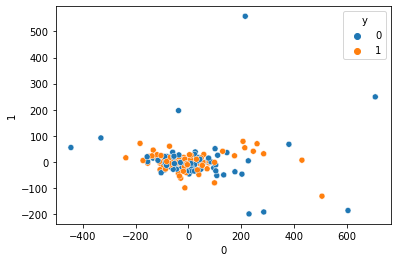

In [12]:
sns.scatterplot(data=res, x=0, y=1, hue="y")

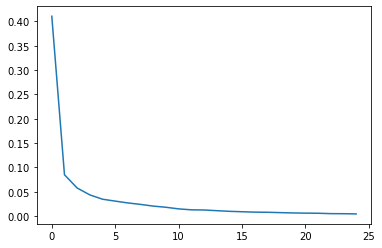

In [13]:
plt.plot(pca.explained_variance_ratio_)

## Repeat with masks

Here I use the brain atlas masks on the normalized beta images for predictions.

In [14]:
!ls masks

BN_Atlas_246_2mm.nii
TPJ_Mask.nii
output_atlas.nii


In [15]:
masks = "masks/BN_Atlas_246_2mm.nii"
files_normed = "subj02/1stLevel_nob0_norm_MVPA_trial_smooth/"
files = "subj02/1stLevel_nob0_MVPA_trial_smooth/"

In [113]:
# defining import functions for mask and nib files

def getmask(name):
    mask_im = nib.load("masks/"+name)
    mask = mask_im.get_fdata()
    return mask

def nibim(name, subj="02"):
    files_normed = f'subj{subj}/1stLevel_nob0_norm_MVPA_trial_smooth/'
    beta_path = files_normed + name
    nimage = nib.load(beta_path)
    return nimage.get_fdata()


In [34]:
# Import the atlas mask
# values are not exact int (prob because of normalization/preprocessing?)

atlasmask = getmask("output_atlas.nii")
atlasmask = atlasmask.round()
print("shape " + str(atlasmask.shape))

shape (53, 63, 52)


### Do the prediction loop

In [147]:
def mask_prediction_loop(subj="02", mode="svm", verbose=False):
    """
    This function loops over the different masks in the brain atlas mask
    For each masks it reads the data from all the beta images and performs classificaiton with svm or rf calsssifier.
    Results are written to a lof file.
    
    param subj: the subject (02 or 07)
    param mode: classifiaction mode (svm or rf (= random forest))
    """
    
    betas = pd.read_csv("intermediate_data/beta_df.csv") # these are the names of the ebta images that we use
    image_mask = getmask("output_atlas.nii")
    image_mask = image_mask.round()
    areas = set(image_mask.flatten()) # unique numbers of the mask file, each number is a different brain region
    betafiles = betas["files"].to_list()
    y_true = betas["labels"].to_list()

    # The results are written to a text file
    time_string = time.ctime().replace(" ","").replace(":","") # so we dont overwrite previous files
    log_file_name = f'subj{subj}_{mode}_result_log_{time_string}.txt'
    
    beta_files = f'subj{subj}/1stLevel_nob0_norm_MVPA_trial_smooth/'
    
    if not os.path.exists(beta_files):
        print("beta files path not found?")
        print(beta_files)
        return None
    
    with open(log_file_name, "w") as file:
        for area in areas:
            df = pd.DataFrame()
            
            for b in betafiles:
                try:
                    beta_im = nibim(b, subj)
                except FileNotFoundError:
                    print("couldnt find file: " + b)
                    continue
                subset = beta_im[image_mask==area]
                df[b] = subset
                
            # classify
            nanas = df.isna().sum().sum()
            
            if nanas>0:
                df = df.dropna()
                if verbose:
                    print("Area: "+str(area))
                    print("dropped NaNs: "+ str(nanas))

                
            if mode=="rf":
                X_train, x_test, Y_train, y_test = train_test_split(df.T,y_true)
                clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, min_samples_leaf=8)
                clf.fit(X_train, Y_train)
                y_pred = clf.predict(x_test)
                acc = accuracy_score(y_pred, y_test)

            elif mode=="svm":                   
                clf = svm.SVC(kernel='linear', C=1, random_state=42)
                acc = cross_val_score(clf, df.T, y_true, cv=KFold(n_splits=4, random_state=None, shuffle=False))
            else:
                print(f'not defined mode {mode}')

            if verbose:
                print(acc)

            file.write(f'Area, {area}, Accuracy, {acc}\n')
                
    return None
                
                

### With SVM


In [149]:
mask_prediction_loop(subj="02", mode="svm", verbose=False)
# mask_prediction_loop(subj="07", mode="svm", verbose=True)

### Results analysis

In [107]:
!ls *.txt

result_log.txt
subj02_svm_result_log_WedJun10950582022.txt
svm_result_log.txt
svm_result_log_FriMay271339312022.txt


In [22]:
rf = pd.read_csv("result_log.txt", header=None)[[1,3]]
rf.columns = ["area", "acc"]
res_svm = pd.read_csv("svm_result_log.txt", header=None)[[1,3]]
res_svm.columns = ["area", "acc"]

In [23]:
def get_c_lb(data):    
    temp=data.copy()
    temp["unpacked"] = temp["acc"].apply(lambda x: [y.replace("[","").replace("]","").strip().rstrip() for y in x.split(" ") if y != ''])
    temp["unpacked"] = temp["unpacked"].apply(lambda x: [y for y in x if y != ''])
    temp["unpacked"] = temp["unpacked"].apply(lambda x: [y for y in x if y != '.'])

    svm_scores = pd.DataFrame(temp["unpacked"].to_list(), columns=[1,2,3,4], dtype=float)
    mean_acc = svm_scores.mean(axis=1)
    std_acc = svm_scores.std(axis=1)
    
    # compute the confidence intervals lower bounds
    alpha = 0.95
    n=4
    
    # Define our z
    ci = alpha + (1-alpha)/2
    
    #Lower Interval, where n is sample siz
    c_lb = mean_acc - norm.ppf(ci)*((std_acc/(n**0.5)))
    c_ub = mean_acc  + norm.ppf(ci)*((std_acc/(n**0.5)))
    return c_lb

In [26]:
res_svm["c_lb"] = get_c_lb(res_svm)

In [31]:
# Here I map/expand the prediction scores (which we only have one per area) to the x,y,z coordinates of every voxel

key = res_svm["area"].to_list()
key.append(82.)
key.append(0.)
value = res_svm["c_lb"].to_list()
value.append(0.)
value.append(0.)
atlas_map = dict(zip(key,value))

In [35]:

atlas = atlasmask.copy()

x, y, z = np.where(atlas>-1)
atlas_data=pd.DataFrame(np.transpose(np.array([x,y,z])),columns=['x','y','z'])
atlas_data['value']=np.transpose(atlas).flatten('F')
atlas_data['value']=round(atlas_data['value'])

atlas_data["Acc_lb"] = atlas_data["value"].apply(lambda x: atlas_map[x])


In [41]:
atlas_data = atlas_data.query("Acc_lb > 0")

In [70]:
def brain_plot(data):
    ## plot the accuracy as a brain shape
    plt.rcParams["figure.figsize"] = [10,10]
    fig = plt.figure()
    ax = fig.gca(projection='3d')


    # brain
    img=ax.scatter(data.x, data.y, data.z,c=data.Acc_lb, cmap='Reds',alpha=1, marker="s",  s=50)
    cbar=fig.colorbar(img,fraction=0.025)
    cbar.set_label('Accuracy ', rotation=270, fontsize = 15, labelpad=20)
    plt.xlabel("X")
    plt.ylabel("Y")
    
    return None

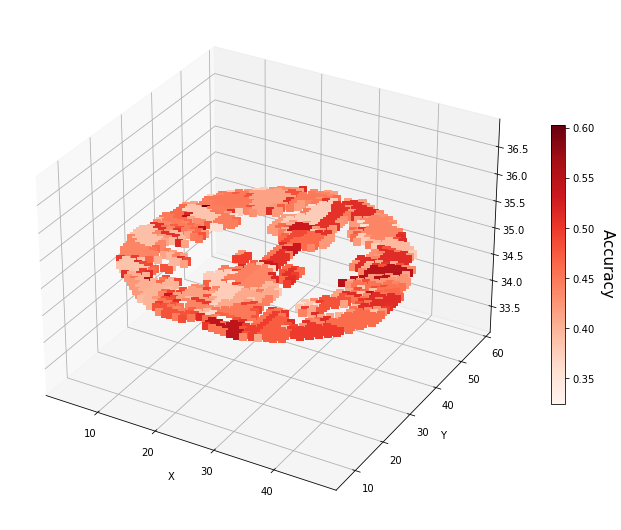

In [100]:
brain_plot(atlas_data.query("z == 35"))

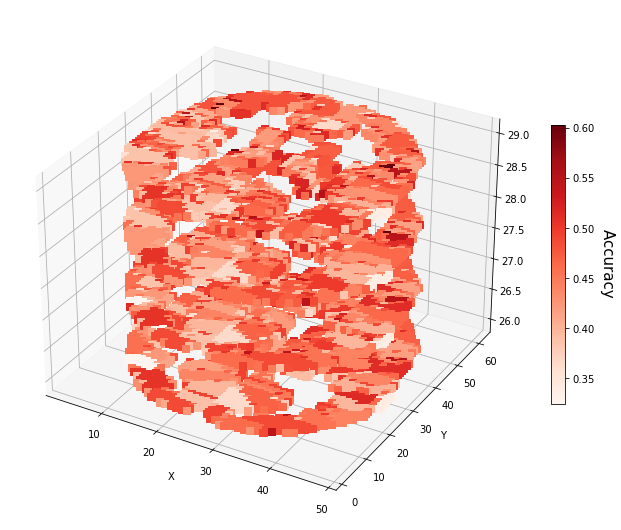

In [104]:
brain_plot(atlas_data.query("z > 25 and z < 30"))

In [86]:
my_func = lambda x: atlas_map[x]
vfunc = np.vectorize(my_func)

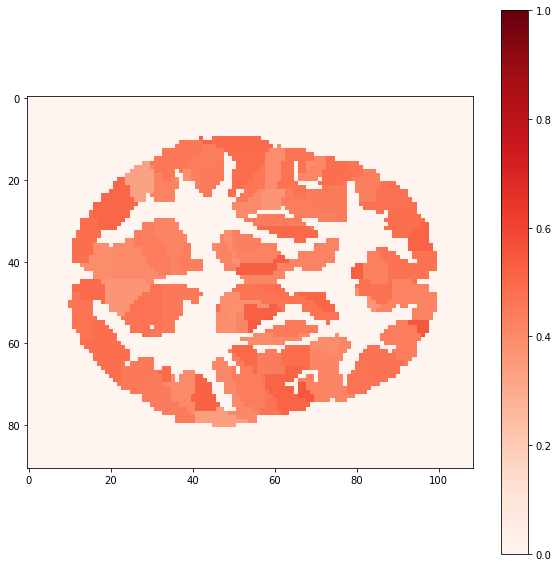

In [98]:
plt.imshow(vfunc(mask[:,:,40]), cmap="Reds",vmin=0, vmax=1)
plt.colorbar()

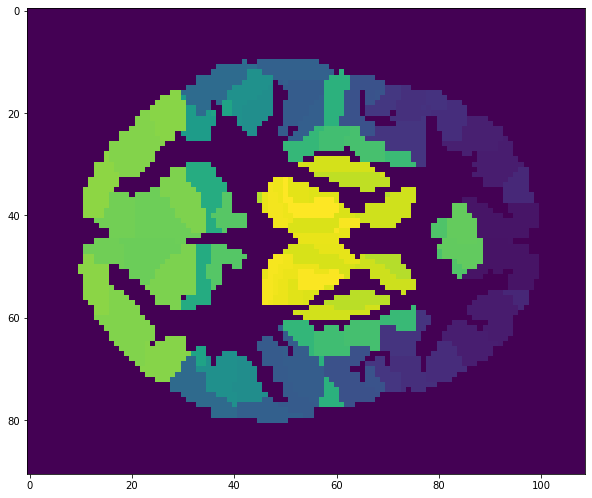

In [75]:
plt.imshow(mask[:,:,40])

In [277]:
betaim = nibim(beta_, files_normed)
betaim.shape

(53, 63, 52)

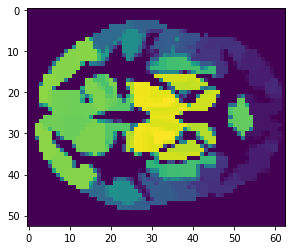

In [289]:
plt.imshow(atlasmask[:,:,25])

In [292]:
atlasmask = atlasmask.round()

In [297]:
betaim[atlasmask==1].shape

(332,)

In [299]:
betaim.shape

(53, 63, 52)

In [294]:
(atlasmask==area).shape

(53, 63, 52)

In [ ]:

area=1
mask_ = mask[mask==area]
coord_brain=np.argwhere(mask_im>0)
x, y, z = np.where(mask_im>-1)

data_table=pd.DataFrame(np.transpose(np.array([x,y,z])),columns=['x','y','z'])

In [274]:
beta_

'beta_0001.nii'

In [233]:
set(mask.flatten())

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0

In [ ]:
im = nib.load(betap+"/beta_0010.nii")
bdat = im.get_fdata()

In [159]:
counts = [y for y in x if "beta" in y]

220

### Now with PyTorch

In [145]:
import torch
from torchvision import datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader as DataLoader
from torchvision import transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [ ]:
transform = transforms.Compose(
                                [transforms.ToTensor(),
                                 transforms.Normalize( (0.1307,), (0.3081,))])

In [ ]:
data = datasets.MNIST(root="./data", download=True)

In [ ]:
data = datasets.MNIST(root="./data", transform=transform)